# DATA 11800 (Section 1), Autumn 2023

# Homework 7: A/B testing and fuzzy matching (50 points)

Please complete this notebook by filling in the cells provided.

The solved homework should be uploaded to Canvas as an .ipynb file. DO NOT put your answers in more than one file or use a different file extension.

Make sure to RUN ALL CELLS IN YOUR NOTEBOOK before submitting.  All of your answers should be printed and easy for graders to find if you want full credit for your work.


#### Deadline:

This assignment is due on **Friday, December 1 at 11:59pm**. Late work will not be accepted unless you have made special arrangements with the instructor.

Directly sharing answers is not okay, but discussing problems with the course staff is encouraged, and with other students is allowed.

You should start early so that you have time to get help if you're stuck.


In [3]:
# Don't change this cell; just run it. 

import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# 1. Possum metrology (25 points) 

The data for this exercise were collected in Australia and New Guinea and represent various measurements of possum dimensions of 102 animals caught at 7 locations in Victoria, New South Wales, and Queensland in October and November of 1993. Source of data: 

Lindenmayer, D. B., Viggers, K. L., Cunningham, R. B., and Donnelly, C. F. 1995. Morphological variation among columns of the mountain brushtail possum, Trichosurus caninus Ogilby (Phalangeridae: Marsupiala). Australian Journal of Zoology 43: 449-458. 

Variables in the dataset:

- site: one of seven locations where possums were trapped. The sites were, in order, Cambarville, Bellbird, Whian Whian, Byrangery, Conondale, Allyn River and Bulburin
- pop:  a factor which classifies the sites as Vic (for Victoria) and other (New South Wales or Queensland)
- sex: a factor with levels f (female), m (male)
- age
- head_l:  head length
- skull_w:  skull width
- total_l: total length
- tail_l: tail length

We believe that the units for `age` is  years, for `head_l`, `skull_w` and `tail_l` are mm; possums are about 20 inches long so let's assume that `total_l` is in cm.  


In [4]:
# read the data
p_df = pd.read_csv("possum.csv")
p_df.head()

,site,pop,sex,age,head_l,skull_w,total_l,tail_l
0,1,Vic,m,8.0,94.1,60.4,89.0,36.0
1,1,Vic,f,6.0,92.5,57.6,91.5,36.5
2,1,Vic,f,6.0,94.0,60.0,95.5,39.0
3,1,Vic,f,6.0,93.2,57.1,92.0,38.0
4,1,Vic,f,2.0,91.5,56.3,85.5,36.0


In [5]:
# some data summaries
p_df.describe()

,site,age,head_l,skull_w,total_l,tail_l
count,104.000000,102.000000,104.000000,104.000000,104.000000,104.000000
mean,3.625000,3.833333,92.602885,56.883654,87.088462,37.009615
std,2.349086,1.909244,3.573349,3.113426,4.310549,1.959518
min,1.000000,1.000000,82.500000,50.000000,75.000000,32.000000
25%,1.000000,2.250000,90.675000,54.975000,84.000000,35.875000
50%,3.000000,3.000000,92.800000,56.350000,88.000000,37.000000
75%,6.000000,5.000000,94.725000,58.100000,90.000000,38.000000
max,7.000000,9.000000,103.100000,68.600000,96.500000,43.000000


**Question 1.** Produce an adequately-labeled scatterplot of total length (y axis) vs. age (x axis). Explain why the plot has prominent vertical lines.

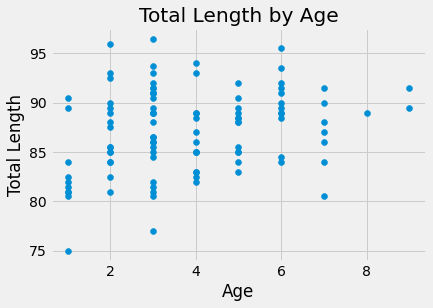

In [6]:
# code here
plt.scatter(y=p_df.total_l, x=p_df.age)
plt.xlabel("Age")
plt.ylabel("Total Length")
plt.title("Total Length by Age")
plt.show()

*Answer:* The plot has prominent vertical lines because elements in the age Series are whole numbers. Due to this, there won't be any data points on non-whole number x-values.


**Question 2.** Test for sexual dimorphism in the skull width measurement in the sampled possums.  (Do the male and female possums have different skull widths?)  This should be done using the permutation method. Display the (permutation generated) null distribution of your test statistic and the observed value of the test statistic. Report the p-value for this null hypothesis that the two sexes have the same skull width distribution.

Observed Difference: 0.5034311856652636
Empirical P-value: 0.4299


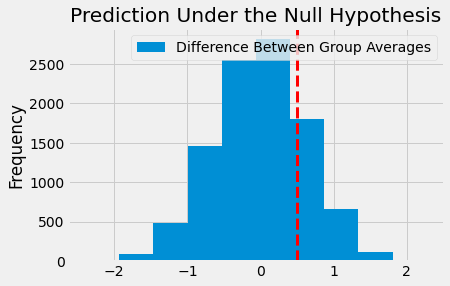

In [7]:
differences = np.array([])

for i in np.arange(10_000):
    shuffled_weights = p_df.sample(frac=1, replace = False).skull_w.values
    shuffled_df=pd.DataFrame({"Shuffled Weights": shuffled_weights,"Sex": p_df.sex})
    smeans_df=shuffled_df.groupby('Sex').mean()
    new_diff=smeans_df.iloc[1]-smeans_df.iloc[0]
    differences = np.append(differences, new_diff)

observed_means = p_df[["sex", "skull_w"]].groupby("sex").mean().skull_w
observed_difference = observed_means[1] - observed_means[0]
empirical_P = (np.count_nonzero(differences >= observed_difference) + np.count_nonzero(differences <= -observed_difference)) / 10000

pd.DataFrame({'Difference Between Group Averages': differences}).plot.hist()
plt.axvline(x=observed_difference, color='red', linestyle='dashed', linewidth='3')
plt.title('Prediction Under the Null Hypothesis')
print('Observed Difference:', observed_difference)
print('Empirical P-value:', empirical_P)

**Question 3.** Similarly to Question 2, test the hypothesis of equality in distributions for the tail lengths of male possums sampled in Victoria (sites 1 and 2) and the tail lengths of male possums sampled outside of Victoria.

This should be done using the permutation method. Display the (permutation generated) null distribution of your test statistics and the observed value of the test statistic. Report the p-value for this null hypothesis that the two groups have the same tail length distribution.

site
0    37.75641
1    35.50000
Name: tail_l, dtype: float64
Observed Difference: -2.2564102564102555
Empirical P-value: 2.0


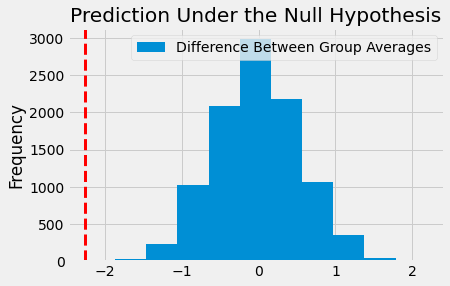

In [8]:
# code here
differences = np.array([])

for i in np.arange(10_000):
    shuffled_weights = p_df.loc[p_df.sex == "m"].sample(frac=1, replace = False).tail_l.values
    shuffled_df=pd.DataFrame({"Shuffled Weights": shuffled_weights, "Site": p_df.loc[p_df.sex == "m"].site})
    shuffled_df.Site = np.where((shuffled_df.Site == 2) | (shuffled_df.Site == 1), 1,0)
    smeans_df=shuffled_df.groupby('Site').mean()
    new_diff=smeans_df.iloc[1]-smeans_df.iloc[0] 
    differences = np.append(differences, new_diff)

df = p_df.loc[p_df.sex == "m"][["tail_l", "site"]]
df.site = np.where((df.site == 2) | (df.site == 1), 1,0)
observed_means = df.groupby('site').mean()["tail_l"]
print(observed_means)
observed_difference = observed_means[1] - observed_means[0]
empirical_P = (np.count_nonzero(differences >= observed_difference) + np.count_nonzero(differences <= -observed_difference)) / 10000

pd.DataFrame({'Difference Between Group Averages': differences}).plot.hist()
plt.axvline(x=observed_difference, color='red', linestyle='dashed', linewidth='3')
plt.title('Prediction Under the Null Hypothesis')
print('Observed Difference:', observed_difference)
print('Empirical P-value:', empirical_P)


**Question 4.** Write code that constructs a 2x2 table that shows the counts of sex (female and male) in the two sites (Victoria and other)

In [18]:
# code here
df4=pd.DataFrame({"Sex": p_df.sex, "Site": p_df.site})
df4.Site = np.where((df4.Site == 2) | (df4.Site == 1), "Victoria","Other")
df4 = pd.crosstab(df4['Site'], df4['Sex'])
df4

Sex,f,m
Site,,
Other,19,39
Victoria,24,22


**Question 5.** Investigate the hypothesis that the porportion of males to females is equal in the two sites (perform a hypothesis test on the table you constructed in Question 4 using the permutation method). State clearly the null and alternative hypothesis. After you perform the test and report the p-value, briefly talk about the assumptions in your test.

Observed Difference: -1.135964912280702
Empirical P-value: 0.9774


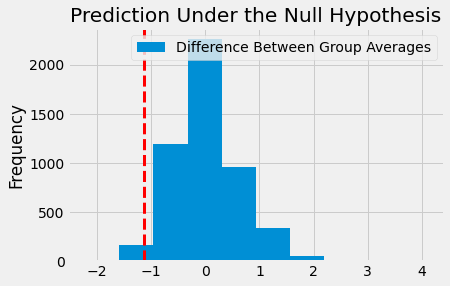

In [19]:
# code here
differences = np.array([])

for i in np.arange(5000):
    shuffled_weights = p_df.sample(frac=1, replace = False).sex.values
    shuffled_df=pd.DataFrame({"Sex": shuffled_weights, "Site": p_df.site})
    shuffled_df.Site = np.where((shuffled_df.Site == 2) | (shuffled_df.Site == 1), 1,0)
    v_m = shuffled_df.loc[(shuffled_df.Site == 1) & (shuffled_df.Sex == 'm')].shape[0]
    v_f = shuffled_df.loc[(shuffled_df.Site == 1) & (shuffled_df.Sex == 'f')].shape[0]
    o_m = shuffled_df.loc[(shuffled_df.Site == 0) & (shuffled_df.Sex == 'm')].shape[0]
    o_f = shuffled_df.loc[(shuffled_df.Site == 0) & (shuffled_df.Sex == 'f')].shape[0]
    new_diff=v_m/v_f - o_m/o_f
    differences = np.append(differences, new_diff)

observed_difference = df4.m[1]/df4.f[1] - df4.m[0]/df4.f[0]
empirical_P = (np.count_nonzero(differences >= observed_difference) + np.count_nonzero(differences <= -observed_difference)) / 10000

pd.DataFrame({'Difference Between Group Averages': differences}).plot.hist()
plt.axvline(x=observed_difference, color='red', linestyle='dashed', linewidth='3')
plt.title('Prediction Under the Null Hypothesis')
print('Observed Difference:', observed_difference)
print('Empirical P-value:', empirical_P)


*Null Hypothesis:* The proportion of males to females is equal in both sites<br>
*Alternative Hypothesis:* The proportion of males to females is not equal in both sites<br>
Assumptions in test?

## 2. Plagiarism detector (25 points) 

We will use the matching techniques discussed in Lecture 16 to construct **a naive plagiarism detector**. We modified the code from the class notebook in two ways: (i) we generalized it to q-character tokens; and (ii) we use spaces instead of #-signs to pad the ends of the strings.

This code allows you to calculate the Jaccard similarity for bigrams, trigrams etc.

In [107]:
#A Function to break a string into qgrams (q-character tokens)
#we'll pad the string with spaces on the front and end
def qgram(str,q):
    str = ' ' + str + ' '
    return([str[i:i+q] for i in range(len(str)-(q-1))])

#compute the jaccard similarity of two strings using qgrams
#pass in a value for q to do anything other than bi-grams
#call jaccard_simq with verbose set to True to see intermediate values

def jaccard_simq(str1, str2,q=2,verbose=False): 
    set1 = set(qgram(str1,q)) 
    set2 = set(qgram(str2,q))
    common_tokens = set1.intersection(set2)
    all_tokens = set1.union(set2)
    if verbose:
        print('set1 =',set1)
        print('set2 =',set2)
        print('Intersection =',common_tokens)
        print('Union =',all_tokens)
        print('Common Tokens =',len(common_tokens),
              'Total Tokens =',len(all_tokens))
    return float(len(common_tokens) / len(all_tokens))


To familiarize yourself with the function, you should try it on several examples and with different values of q. The `verbose=True` option is useful when you want to understand what the function is doing.

In [108]:
jaccard_simq('the quick brown fox','fox quick brown the',verbose=True)

set1 = {'ox', 'wn', 'e ', 'fo', ' q', 'k ', 'br', 'ow', 'qu', 'he', ' t', 'x ', 'ic', ' b', 'ro', 'ck', 'n ', ' f', 'ui', 'th'}
set2 = {'ox', 'wn', 'e ', 'fo', ' q', 'k ', 'br', 'ow', 'qu', 'he', ' t', 'x ', 'ic', ' b', 'ro', ' f', 'ck', 'n ', 'ui', 'th'}
Intersection = {'ox', 'wn', 'e ', 'fo', ' q', 'k ', 'br', 'ow', 'qu', 'he', ' t', 'x ', 'ic', ' b', 'ro', ' f', 'ck', 'n ', 'ui', 'th'}
Union = {'ox', 'wn', 'e ', 'fo', ' q', 'k ', 'br', 'ow', 'qu', 'he', ' t', 'x ', 'ic', ' b', 'ro', 'ck', 'n ', ' f', 'ui', 'th'}
Common Tokens = 20 Total Tokens = 20


1.0

In [109]:
jaccard_simq('the quick brown fox','fox quick brown the')

1.0

In [110]:
jaccard_simq('the quick brown fox','fox quick brown the',4,True)

set1 = {'the ', 'ick ', ' bro', 'rown', 'quic', 'ck b', 'e qu', 'wn f', 'uick', 'n fo', ' the', ' fox', 'fox ', 'he q', 'k br', ' qui', 'brow', 'own '}
set2 = {'ick ', ' bro', 'rown', 'ox q', 'the ', 'n th', 'quic', 'ck b', 'x qu', 'uick', ' the', 'fox ', ' fox', 'wn t', 'k br', ' qui', 'brow', 'own '}
Intersection = {'ick ', 'the ', ' bro', ' qui', 'quic', 'uick', ' the', 'fox ', 'brow', ' fox', 'k br', 'ck b', 'rown', 'own '}
Union = {'ick ', 'e qu', 'wn f', ' fox', 'k br', ' qui', 'own ', 'the ', ' bro', 'ox q', 'n th', 'quic', 'x qu', 'n fo', 'uick', ' the', 'fox ', 'brow', 'he q', 'wn t', 'ck b', 'rown'}
Common Tokens = 14 Total Tokens = 22


0.6363636363636364

In [111]:
jaccard_simq('the quick brown fox','fox quick brown the',10)

0.2

The goal of this exercise is to use this function to investigate possible plagiarism in a homework assignment. A homework question asked students to define PageRank. The instructors were worried that the students will copy the answer from Wikipedia, so they decided to use that as a reference. The relevant part of the Wikipedia entry is saved in the file `original.txt` and the command below reads that file into a string.

In [112]:
open("original.txt","r",encoding="utf8").read()

'PageRank is a link analysis algorithm used by the Google Internet search engine that assigns a numerical weighting to each element of a hyperlinked set of documents, such as the World Wide Web, with the purpose of "measuring" its relative importance within the set. The algorithm may be applied to any collection of entities with reciprocal quotations and references. The numerical weight that it assigns to any given element E is also called the PageRank of E and denoted by PR(E).\nThe name "PageRank" is a trademark of Google, and the PageRank process has been patented (U.S. Patent 6,285,999 ). However, the patent is assigned to Stanford University and not to Google. Google has exclusive license rights on the patent from Stanford University. The university received 1.8 million shares in Google in exchange for use of the patent; the shares were sold in 2005 for $336 million.\nGoogle describes PageRank:\n" \tPageRank relies on the uniquely democratic nature of the web by using its vast lin

Files containing the answer of five students (A,B,C,D, and E) are provided. They are read as strings using the code below. 

In [113]:
original=open("original.txt","r").read()
studentA=open("studentA.txt","r").read()
studentB=open("studentB.txt","r").read()
studentC=open("studentC.txt","r").read()
studentD=open("studentD.txt","r").read()
studentE=open("studentE.txt","r").read()

from collections import namedtuple
Entry = namedtuple("Entry", ["name", "entry"])
og = Entry(name="original", entry=original)
students = [
    Entry(name="studentA", entry=studentA), 
    Entry(name="studentB", entry=studentB), 
    Entry(name="studentC", entry=studentC), 
    Entry(name="studentD", entry=studentD), 
    Entry(name="studentE", entry=studentE)
]


#### Question 1

One decision to make is the choice of q in the Jaccard similarity (whether to use 2-character tokens, 20-character tokens etc.) 

Write one advantage and one disadvantage when using 2-character tokens.

Write one advantage and one disadvantage when using 20-character tokens.

A) Advantage: will work on shorter texts
Disadvantage: will output high numbers in a variety of the more similar cases, making them near indistinguishable

B) Advantage: will only output high numbers in the most similar of cases, making them easily distinguishable
Disadvantage: will not perform on texts shorter than 20 characters (making it useless for many cases)

#### Question 2

Calculate the Jaccard similarities between each of the five student responses and the original Wikipedia article. This should be done for all q between 2 and 20.

Save the results in a dataframe with rows indexed by the values of q, and having a column for each student answer showing the similarity of that student answer and the original for each value of q.   Your dataframe should have 19 populated rows with 5 columns.

In [114]:
# put your code to create and output the dataframe here
pre_df = {'q': np.arange(2, 21)}
for student in students:
    vals = []
    for q in pre_df['q']:
        vals.append(jaccard_simq(og.entry, student.entry, q))
    pre_df[student.name] = vals

jacc_df = pd.DataFrame(pre_df)
jacc_df.set_index('q', inplace=True)
jacc_df

,studentA,studentB,studentC,studentD,studentE
q,,,,,
2,0.716895,0.453831,0.448578,0.416476,0.453159
3,0.528974,0.268646,0.231821,0.245298,0.284252
4,0.458564,0.165417,0.128228,0.177585,0.200730
5,0.425445,0.110250,0.079319,0.151137,0.165950
6,0.402592,0.079199,0.048025,0.132120,0.147679
7,0.387472,0.055462,0.028356,0.118508,0.134567
8,0.375356,0.040000,0.015565,0.108605,0.125678
9,0.366289,0.028165,0.008412,0.100635,0.120865
10,0.358837,0.020438,0.003325,0.094370,0.117722


#### Question 3

Draw a plot with five overlaid lines for the Jaccard similarities of the five texts. The plot should show the Jaccard similarities (on y-axis) against q (on x-axis). Make sure that it is clear which line corresponds to which student/answer.

<AxesSubplot:title={'center':'Student-Wiki Jaccard Similarity by Q-Value'}, xlabel='q', ylabel='Jaccard Similarity'>

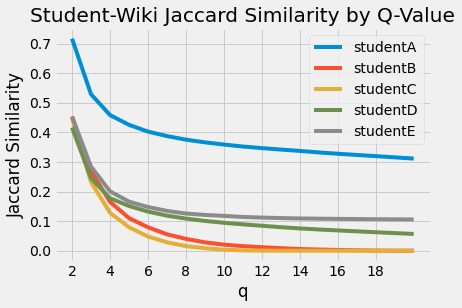

In [115]:
# the code to draw the plot
jacc_df.plot(kind='line', xticks=np.arange(2, 20, 2), ylabel="Jaccard Similarity", title="Student-Wiki Jaccard Similarity by Q-Value")

#### Question 4

What do the similarity values you calculated say about the five students (A,B,C, D and E)? Is there evidence for plagiarism for any of them? Write a short discussion of your findings.


With the exception of q-values <= 4, similarity values of students B, C, D, and E are generally low, with students B and C flattening out to at 0.0 jaccard similarity and students D and E flattening out to below 0.12 jaccard similarity. Student A can be highlighted as a potential suspect of plagiarism as their jaccard similarity, even at relatively high token lengths, still is above 0.4 which is already a very sizeable similarity value. If I was a professor viewing these results, I would absolutely have concerns about the legitimacy of Student A's paper, but not of the others.

#### Question 5

Assume that the original text is fixed, but that different amounts of it are plagiarized.  How does the length of the plagiarized text impact the Jaccard similarities? For example, would a plagiarized short paper (1-2 sentences) typically have a different Jaccard similarity than a plagiarized long paper (few paragraphs)? Is this important for our five student scenario?

This is an open-ended question. You can answer it by changing the length of a plagiarized text and calculating similarities, you can argue it mathematically, or you can do some combination of these. 



In [116]:
# if you use code to make your argument put it here
plagiarized = og.entry
textlen = len(plagiarized)
plagiarized_short = plagiarized[:textlen // 4]
plagiarized_medium = plagiarized[:textlen // 2]
plagiarized_long = plagiarized[:]

print(jaccard_simq(plagiarized, plagiarized_short, 4))
print(jaccard_simq(plagiarized, plagiarized_medium, 4))
print(jaccard_simq(plagiarized, plagiarized_long, 4))

0.32417274256870443
0.5852017937219731
1.0


The longer the length of plagiarized text, the higher the value will be. This is important for our five student scenario as if a student wrote a shorter response that was entirely plagiarized it could potentially be missed when it should not be.